In [3]:
import sys
import os
# sys.path.append('/home/beinhaud/diplomka/mcs-source/evaluation_tools')
sys.path.append('/home/david/source/diplomka/evaluation_tools')
sys.path.append('/home/david/source/diplomka/results_analysis_tools')
from typing import List, Dict, Any, Tuple, Union

from evaluation_tools.plugins.predictions_analyzer import PredictionsAnalyzer
from evaluation_tools.plugins.wandb_processor import WandbProcessor
from evaluation_tools.fields.experiment_parameters_fields import WandbExperimentVariants, GridSearchRunVariants, ModelEvaluationRunVariant, AdditionalExperiments
from evaluation_tools.fields.prediction_analysis_fields import (
    BatchSummaryFields,
    EvaluationPairsVariants,
)
from evaluation_tools.fields.dataset_analyzer_fields import AnalysisFields, DatasetVariantField
from evaluation_tools.fields.evaluation_processor_fields import EvaluationProcessorChoices
from nn_model.type_variants import EvaluationFields
import nn_model.globals

import pandas as pd
import numpy as np

from results_analysis_tools.result_analyzer import ResultAnalyzer
from evaluation_tools.fields.dataset_parameters import ALL_TIME_STEP_VARIANTS
from results_analysis_tools.fields.experiment_analyses import (
    PlottingVariants,
    PluginVariants,
)
from results_analysis_tools.results_plotter import ResultsPlotter
from results_analysis_tools.plugins.dataset_results_processor import DatasetResultsProcessor

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.interpolate import interp1d

from evaluation_tools.fields.dataset_analyzer_fields import StatisticsFields
from results_analysis_tools.plugins.histogram_processor import DatasetHistogramProcessor
from results_analysis_tools.plugins.temporal_evolution_processor import TemporalEvolutionProcessor
from results_analysis_tools.plugins.synchrony_experiments_processor import SynchronyExperimentsProcessor
from results_analysis_tools.plugins.evaluation_results_processor import EvaluationResultsProcessor
from results_analysis_tools.plugins.wandb_summary_processor import WandbSummaryProcessor
from results_analysis_tools.plugins.batch_prediction_analysis_processor import BatchPredictionAnalysisProcessor

from nn_model.globals import MODEL_SIZES


In [4]:
PLOTING_DESTINATION = "/home/david/source/diplomka/thesis_plots/"
EVALUATION_RESULTS_BASE = "/analysis_results"
analysis_paths = {
    EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.FULL_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS.value}/",
    EvaluationProcessorChoices.WANDB_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.WANDB_ANALYSIS.value}/results.pkl",
    EvaluationProcessorChoices.PREDICTION_ANALYSIS: f"{nn_model.globals.PROJECT_ROOT}{EVALUATION_RESULTS_BASE}/{EvaluationProcessorChoices.PREDICTION_ANALYSIS.value}/",
}
result_analyzer = ResultAnalyzer(analysis_paths)
all_results = result_analyzer.get_all_results
all_results.keys()
# all_results[EvaluationProcessorChoices.PREDICTION_ANALYSIS]


File prediction_analysis-simple_evaluation.pkl does not exist. Skipping!
File prediction_analysis-syn_only_lgn_10_evaluation.pkl does not exist. Skipping!
File prediction_analysis-syn_adapt.pkl does not exist. Skipping!


dict_keys([<EvaluationProcessorChoices.FULL_DATASET_ANALYSIS: 'full_dataset'>, <EvaluationProcessorChoices.SUBSET_DATASET_ANALYSIS: 'subset_dataset'>, <EvaluationProcessorChoices.WANDB_ANALYSIS: 'wandb_analysis'>, <EvaluationProcessorChoices.PREDICTION_ANALYSIS: 'prediction_analysis'>])

In [5]:
# All models for which we have the evaluation results
model_batch_results = [
    ModelEvaluationRunVariant.SIMPLE_LEAKYTANH,
    ModelEvaluationRunVariant.DNN_JOINT_POISSON,
    ModelEvaluationRunVariant.RNN_BACKPROPAGATION_10_POISSON,
    ModelEvaluationRunVariant.SYN_ADAPT_BACKPROPAGATION_10_POISSON
]

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines


In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np  # Needed for np.linspace

def plot_comparison_synchrony_curves_across_layers(df: pd.DataFrame, save_fig: str = ""):
    """
    Plot synchrony curves across layers (columns) for multiple models (rows),
    labeling only the leftmost plots of each row with A, B, C and adding a bottom legend.
    """
    ordered_layers = ["V1_Exc_L4", "V1_Exc_L23", "V1_Inh_L4", "V1_Inh_L23"]
    df["layer_name"] = pd.Categorical(df["layer_name"], categories=ordered_layers, ordered=True)
    
    pretty_layer_names = {
        "V1_Exc_L4": "L4 Excitatory ",
        "V1_Exc_L23": "L2/3 Excitatory ",
        "V1_Inh_L4": "L4 Inhibitory ",
        "V1_Inh_L23": "L2/3 Inhibitory ",
    }

    ordered_models = [
        "simple (leakytanh)",
        "dnn joint - poisson loss",
        "rnn (10 steps) - poisson loss",
        "syn adapt (10 steps) - poisson loss"
    ]
    row_labels = ['Simple', 'DNN', 'RNN', 'Syn. Depr.']
    df["model_variant"] = pd.Categorical(df["model_variant"], categories=ordered_models, ordered=True)
    df.columns.name = None
    df["time_ms"] = df["time"] * 20

    g = sns.relplot(
        data=df,
        x="time_ms",
        y="synchrony",
        kind="line",
        hue="variant_type",
        style="variant_type",
        row="model_variant",
        col="layer_name",
        facet_kws={"sharey": 'col', "sharex": True},
        height=4,
        aspect=1.25,
        linewidth=3,
        errorbar=None,
        palette="colorblind"
    )

    # Add vertical stimulus change line
    def add_vline(data, color, **kwargs):
        plt.axvline(
            nn_model.globals.IMAGE_DURATION,
            color="gray",
            linestyle="--",
            linewidth=2.2,
        )
    g.map_dataframe(add_vline)

    # Add grid lines
    g.map(lambda *args, **kwargs: plt.grid(True, linestyle=":", linewidth=0.4, alpha=0.6))

    # Axis labels
    g.set_axis_labels("Time (ms)", "Ratio of Spiking Neurons", size=17)
    g.set_titles("")  # Remove col/row template titles

    # Annotate each row
    for i, ax_row in enumerate(g.axes):
        ax = ax_row[0]
        ax.annotate(
            row_labels[i],
            xy=(0, 1.15),
            xycoords='axes fraction',
            xytext=(-0.1, 1.15),
            textcoords='axes fraction',
            fontsize=20,
            fontweight='bold',
            va='center',
            ha='center',
            annotation_clip=False
        )

    # Y-axis: 4 ticks per subplot
    num_ticks = 4
    for ax in g.axes.flat:
        ymin, ymax = ax.get_ylim()
        fixed_yticks = np.linspace(ymin, ymax, num_ticks)
        ax.set_yticks(fixed_yticks)
        ax.set_yticklabels([f"{y:.4f}" for y in fixed_yticks], fontsize=12)
        ax.tick_params(axis='both', labelsize=12)

    # Column titles
    for i, ax in enumerate(g.axes[0]):
        ax.set_title(pretty_layer_names[ordered_layers[i]], fontsize=20)

    g.figure.tight_layout(rect=[0.05, 0, 1, 1])  # Leave space at bottom for legend

    # Custom legend at bottom, line by line
    stimulus_line = mlines.Line2D([], [], color="gray", linestyle="--", linewidth=2, label="Stimulus change")
    separator = mlines.Line2D([], [], color="black", linestyle="-", linewidth=0, label="────────────")
    handles, labels = g.axes.flat[0].get_legend_handles_labels()
    g._legend.remove()

    g.figure.legend(
        handles + [separator, stimulus_line],
        ["Predictions", "Target", "────────────", "Stimulus change"],
        loc="lower center",
        fontsize=15,
        title="Variant Type + Marker",
        title_fontsize=16,
        frameon=True,
        ncol=1,
        bbox_to_anchor=(0.0, 0.05)
    )

    if save_fig:
        g.figure.savefig(save_fig, format="pdf", bbox_inches="tight")
    else:
        plt.show()


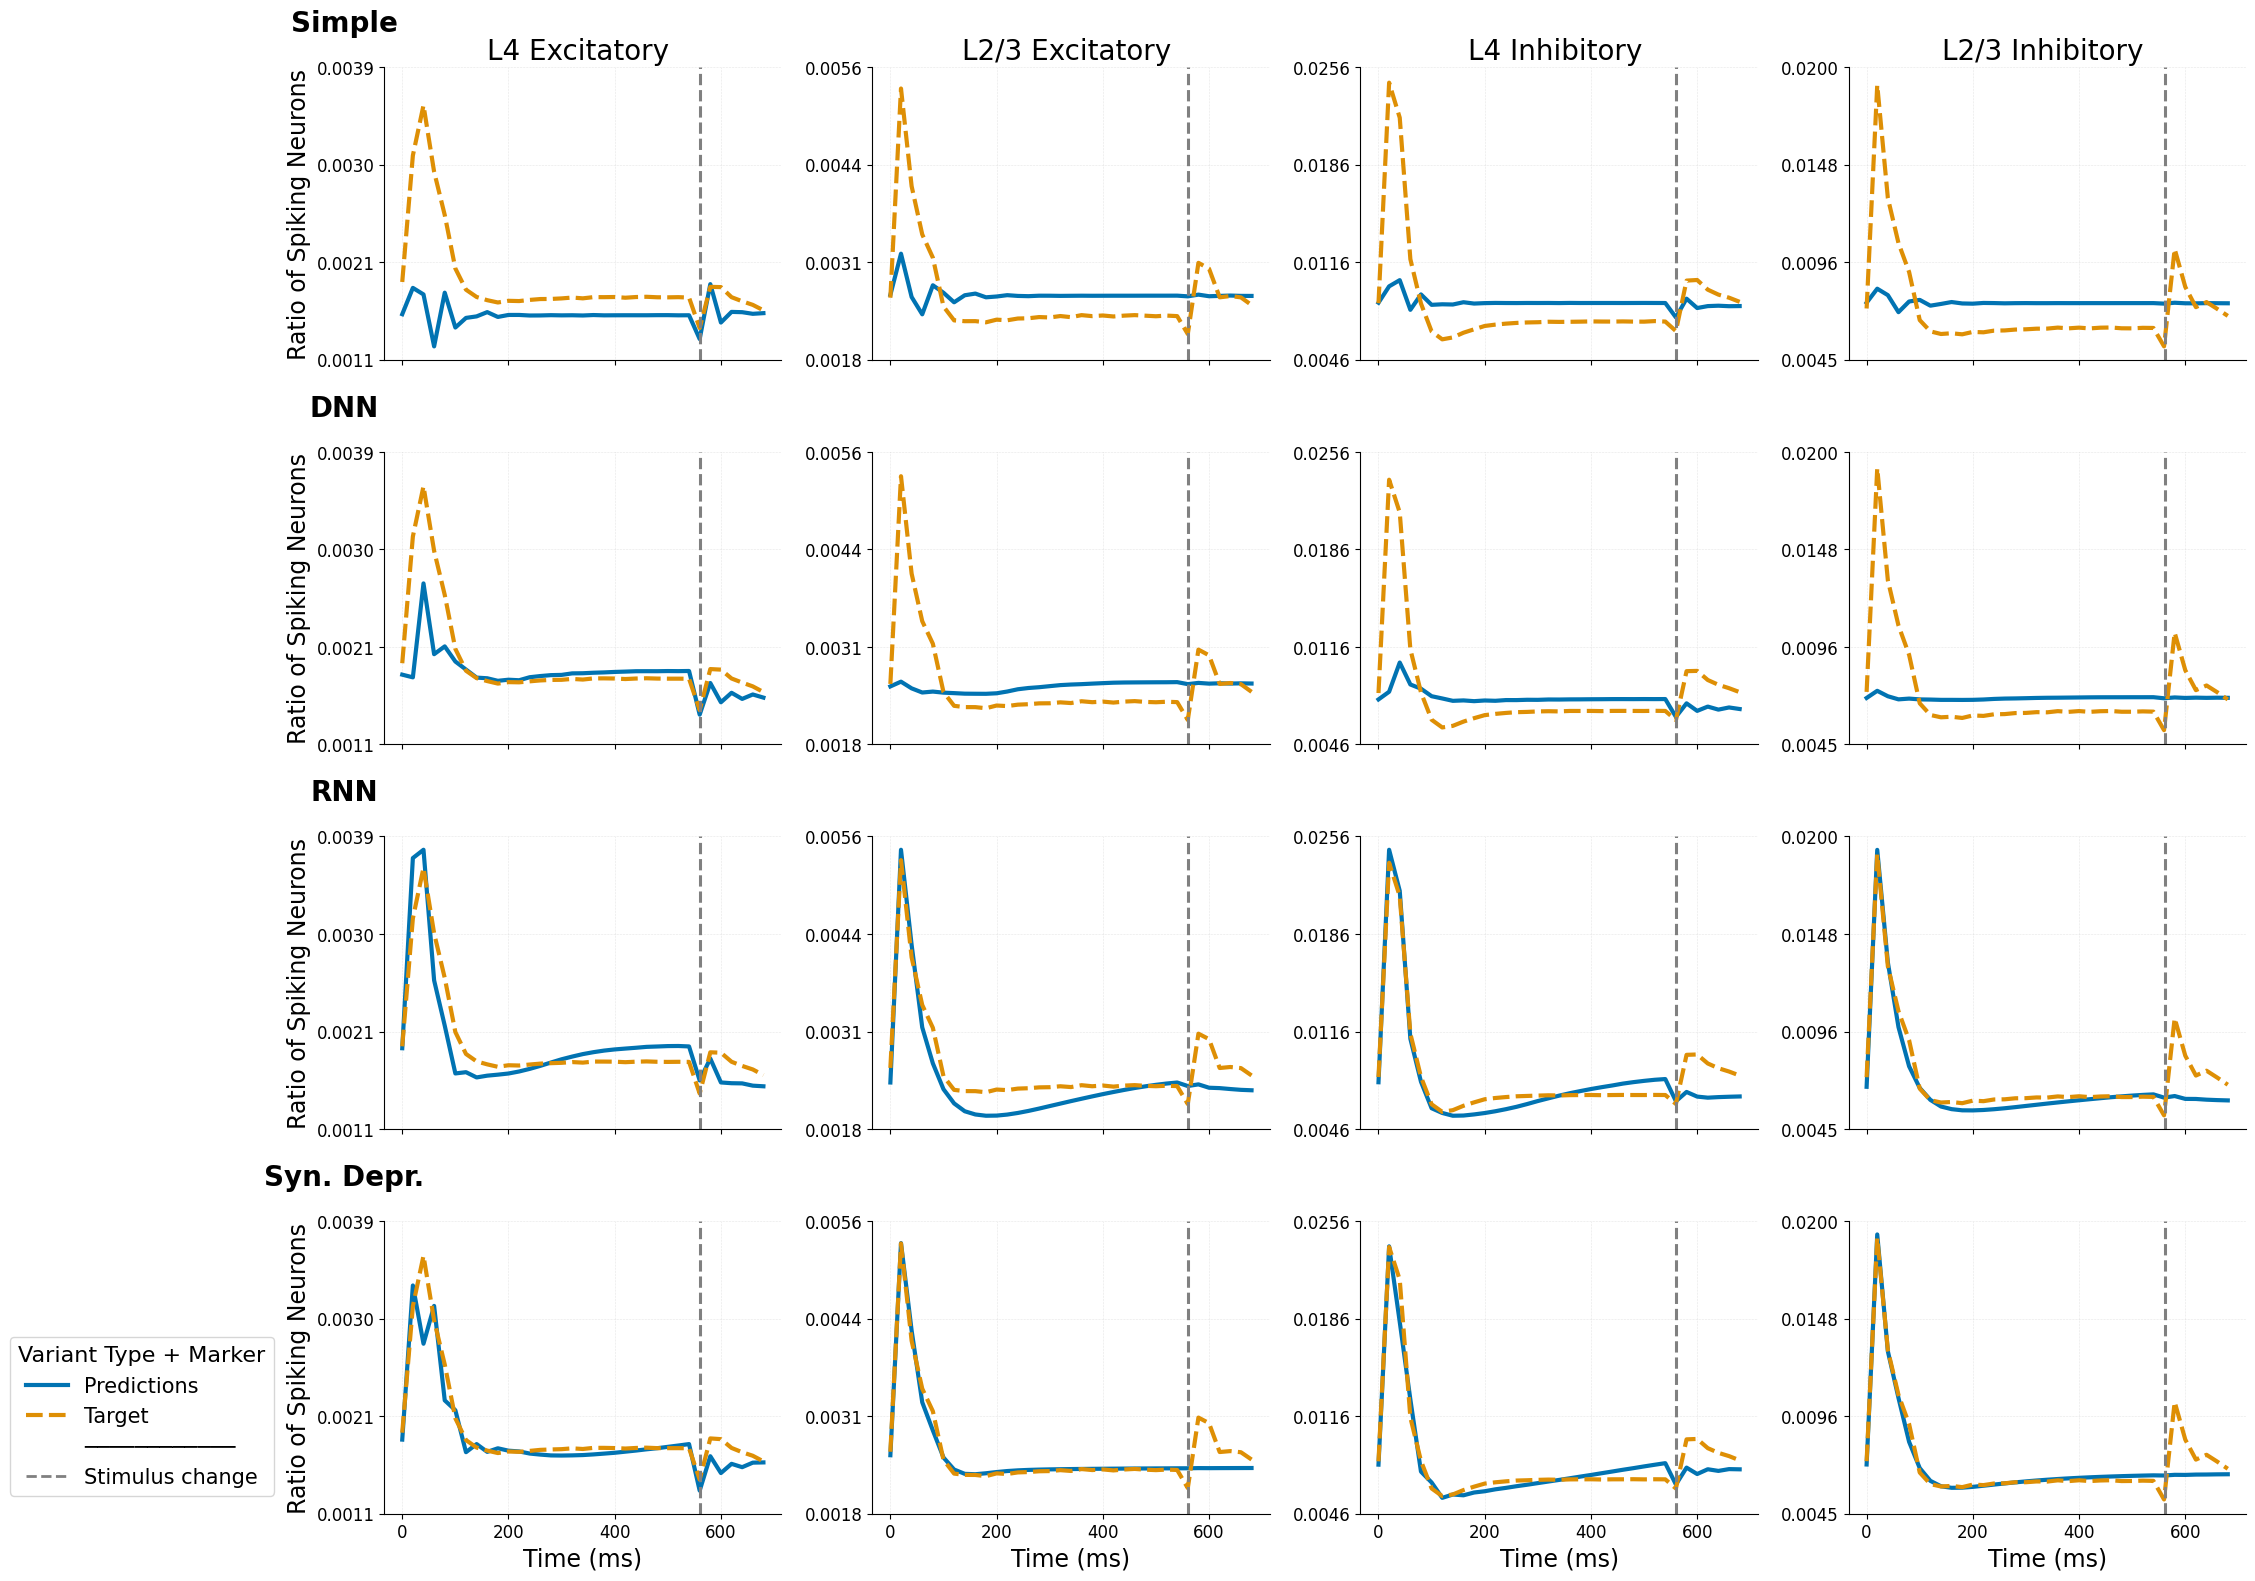

In [18]:
all_model_dfs = []

for model_variant in model_batch_results:
    model_name_pretty = EvaluationResultsProcessor.model_names_mapping_for_plotting[model_variant]
    
    plot_data = result_analyzer.prepare_dataframe_for_plot(
        PlottingVariants.SEPARATE_TEMPORAL_BEHAVIOR_TARGET_PREDICTION,
        synchrony_curve_kwargs={"model_variants": [model_variant]},
    )
    diminisher = 1
    if model_variant == ModelEvaluationRunVariant.DNN_JOINT_POISSON:
        diminisher = 7
    elif model_variant == ModelEvaluationRunVariant.SYN_ADAPT_BACKPROPAGATION_10_POISSON:
        diminisher = 3
    elif model_variant == ModelEvaluationRunVariant.SIMPLE_LEAKYTANH:
        diminisher = 1
    elif model_variant == ModelEvaluationRunVariant.RNN_BACKPROPAGATION_10_POISSON:
        diminisher = 5
    plot_data['synchrony'] /= diminisher
    plot_data['synchrony'] *= 20
    
    plot_data["model_variant"] = model_name_pretty  # Add column for comparison
    all_model_dfs.append(plot_data)

combined_df = pd.concat(all_model_dfs, ignore_index=True)
plot_comparison_synchrony_curves_across_layers(combined_df, save_fig="combined_comparison_plot.pdf")
